In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Merge all data collected from 2013 - 2022
path = r'../data/curated/merged_dataset/'
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

merged_df = pd.concat(li, axis=0, ignore_index=True)

# Rename the columns to facilitate to call them for later
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

LOG_FEATURES = ['saving_rate', 'min_distance_to_prim', 
'min_distance_to_poli', 'min_distance_to_park', 'min_distance_to_second', 'min_distance_to_hosp', 'min_distance_to_cbd', 
'min_distance_to_shop', 'population_density', 'income_per_person', 
'crime_cases', 'min_distance_to_train', 'gdp']
for log_feature in LOG_FEATURES:
    merged_df[log_feature] = np.log(merged_df[log_feature])

merged_df['weekly_rent'] = np.log(merged_df['weekly_rent'])

merged_df = pd.get_dummies(data=merged_df, columns=['sa2_2021'], prefix='sa2')
merged_df = pd.get_dummies(data=merged_df, columns=['residence_type'], prefix='resiType') 
merged_df.drop(['address', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1, inplace=True)

# Check the merged dataframe
merged_df

,year,nbed,nbath,ncar,min_distance_to_cbd,min_distance_to_park,min_distance_to_prim,min_distance_to_second,min_distance_to_train,min_distance_to_hosp,...,sa2_217031473,sa2_217031474,sa2_217031475,sa2_217031476,sa2_217041477,sa2_217041478,sa2_217041479,sa2_217041480,resiType_Apartment,resiType_House
0,2013,2.0,1.0,0,227.97163,23.16035,7.35747,16.96507,35.56825,21.35025,...,0,0,0,0,0,0,0,0,0,1
1,2013,2.0,1.0,0,223.66084,5.71742,6.50536,6.76794,7.54355,7.42972,...,0,0,0,0,0,0,0,0,0,1
2,2013,2.0,1.0,0,243.25680,5.11222,0.20027,36.72106,50.85341,36.63541,...,0,0,0,0,0,0,0,0,0,1
3,2013,4.0,2.0,0,140.35827,78.32509,10.66523,11.91899,11.26906,177.44731,...,0,0,0,0,0,0,0,0,0,1
4,2013,1.0,1.0,0,13.86135,0.93250,1.32931,3.49174,2.20800,177.44731,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172030,2022,3.0,1.0,1,293.28053,0.56012,1.21809,114.77016,90.08591,140.56888,...,0,0,0,0,0,0,0,0,0,1
172031,2022,3.0,2.0,2,258.29111,3.49087,5.08707,3.60570,8.37185,2.60312,...,0,0,0,0,0,0,1,0,0,1
172032,2022,2.0,2.0,1,9.47077,2.45011,1.33931,1.62322,3.63291,140.56888,...,0,0,0,0,0,0,0,0,0,1
172033,2022,1.0,1.0,1,1.84933,0.65199,1.10438,1.27940,1.87840,140.56888,...,0,0,0,0,0,0,0,0,1,0


In [3]:
# Convert the numbers read as string to floats and integers
for col in merged_df.columns:
    if 'resiType' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'year' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'sa2' in col:
        merged_df[col] = merged_df[col].astype(int)
    else:
        merged_df[col] = merged_df[col].astype(float)

# Rename the columns to facilitate to call them for later
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

# Drop Nans
merged_df.dropna(inplace=True)

# Log transformatoin on our target class for better performance 
y = np.log(merged_df['weekly_rent'])

# Assign predictor data to X for training purposes
merged_df.drop('weekly_rent', axis=1, inplace=True)
X = merged_df

print(y)
print(X.dtypes)


0         5.703782
1         5.370638
2         5.164786
3         5.857933
4         5.616771
            ...   
172030    5.579730
172031    6.214608
172032    6.620073
172033    6.013715
172034    5.899897
Name: weekly_rent, Length: 172018, dtype: float64
year                     int64
nbed                   float64
nbath                  float64
ncar                   float64
min_distance_to_cbd    float64
                        ...   
sa2_217041478            int64
sa2_217041479            int64
sa2_217041480            int64
resiType_Apartment       int64
resiType_House           int64
Length: 525, dtype: object


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state= 42)

# Train the model with the training dataset
sel = RandomForestRegressor(n_estimators = 100)
sel.fit(X_train, y_train)

# Get the names of features selected
sel.feature_importances_

array([1.34268854e-02, 9.11019868e-02, 1.53084775e-01, 1.92406111e-02,
       1.14824820e-01, 4.05055227e-02, 4.70710037e-02, 3.24278433e-02,
       2.74177239e-02, 1.59887833e-02, 2.37531682e-02, 9.28695967e-03,
       1.35809137e-02, 1.04015162e-02, 2.52188307e-01, 4.56263305e-02,
       2.61977933e-02, 3.66720268e-05, 8.33711027e-05, 2.18669564e-05,
       3.19727750e-05, 3.72455598e-05, 1.63410837e-05, 2.92301916e-04,
       4.04783344e-05, 4.22675844e-05, 6.15125311e-05, 6.83858087e-05,
       7.57167725e-05, 4.06946320e-04, 3.61968775e-05, 1.25644326e-05,
       3.94687645e-05, 1.37933987e-05, 2.36286503e-06, 4.05908799e-06,
       3.75818399e-04, 3.66103206e-05, 1.20567738e-04, 6.00201536e-05,
       8.74047321e-05, 6.68398730e-06, 1.51858543e-05, 2.01353314e-05,
       6.32771682e-05, 4.48443444e-04, 1.26334488e-04, 1.89015949e-05,
       4.25741512e-05, 7.92214269e-06, 2.47984175e-05, 6.77179934e-05,
       3.08108346e-06, 1.55357731e-05, 6.23957733e-05, 2.26342978e-05,
      

In [8]:
# Make a dictionary with the feature importances calculated from the above cell 
dict = {}

for i in range(len(X.columns)):
    dict[X.columns[i]] = sel.feature_importances_[i]

# Sort the dictinary keys by the values (feature importance values)
sorted_dict = sorted(dict.items(), key=lambda x:x[1])

# Extract information to visualize the features with their importance values
keys = []
vals = []
for i in sorted_dict:
    keys.append(i[0])
    vals.append(i[1])

print(keys, vals)

['sa2_206041127', 'sa2_210051248', 'sa2_206061516', 'sa2_206061515', 'sa2_206041125', 'sa2_211041271', 'sa2_204011061', 'sa2_206041509', 'sa2_210051542', 'sa2_213051584', 'sa2_212041318', 'sa2_208031184', 'sa2_213051585', 'sa2_212031458', 'sa2_206041119', 'sa2_212041564', 'sa2_210051441', 'sa2_212011550', 'sa2_210051543', 'sa2_210051442', 'sa2_213051586', 'sa2_215031403', 'sa2_201031016', 'sa2_206011109', 'sa2_203011034', 'sa2_211011448', 'sa2_211041273', 'sa2_212031556', 'sa2_212031555', 'sa2_201031017', 'sa2_210021234', 'sa2_211051280', 'sa2_215021398', 'sa2_213051581', 'sa2_213051464', 'sa2_213011329', 'sa2_210041539', 'sa2_212021295', 'sa2_206041504', 'sa2_213051588', 'sa2_203021044', 'sa2_211011258', 'sa2_211011449', 'sa2_202011023', 'sa2_216021412', 'sa2_209041435', 'sa2_213041574', 'sa2_216031415', 'sa2_202021031', 'sa2_211011257', 'sa2_215021470', 'sa2_203031048', 'sa2_211051277', 'sa2_211051281', 'sa2_207011154', 'sa2_213051368', 'sa2_211011259', 'sa2_212041565', 'sa2_21105127

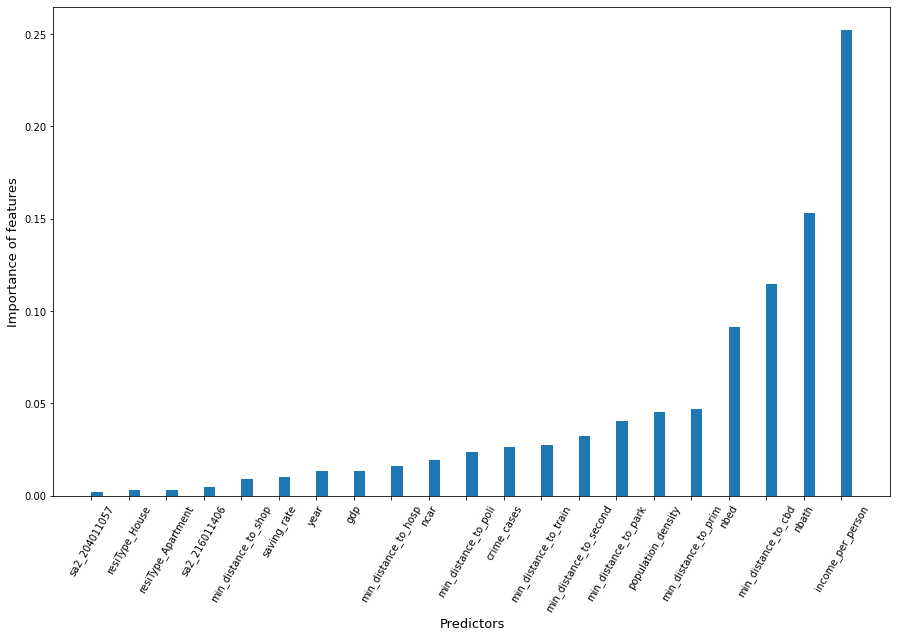

In [10]:
to_graph_keys = keys[-21:]
to_graph_vals = vals[-21:]

plt.figure(figsize=(15, 9)) 
plt.bar(to_graph_keys, to_graph_vals, align='edge', width=0.3)
plt.xticks(rotation=60)
plt.ylabel("Importance of features", fontsize = 13)
plt.xlabel("Predictors", fontsize = 13)
plt.show()

As found above, the most important feature is 'income per person' and the least important feature is residence_type according to the random forest regressor. The values of how important / significant features are computed with the mean and standard deviation of accumulation of the impurity decrease (which means to have stronger sign to predict the target class, weekly_rent) within each tree. </br>
It is interesting that the residence type was not ranked in a higher positino in the feature importance. Since most of our rental property data are categorized under 'house', this may have caused the lowest importance value because under 'house' it has a big range of rental prices. This is a possible limitation about our raw data since we categorized all different kinds of house such as villa or townhouse under 'house' from our team's assumption that customers might want simpler choices given (which are house vs apartment) when they select the property they prefer when using our website. </br>
The other interesitng finding is the predictors do not really seem to have huge contributions. It may indicate that our attributes may not direct factors to predict weekly_rent. Otherwise, it might be caused from our data collection method since the data for each predictor was not able to get collected from one source, hence they are coming from all difference resources and also were labelled with different area granualrities (SA2_2016, SA2_2021, postcodes etc).

In [11]:
# Scrutinize the data with PCA: Test the attribute relevance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

: 

: 

Since the predictors all have feature importances lower than 30%, it was hard to choose what features to drop from the input dataset of our prediction model. Therefore, PCA feature selection was also implemented to see how many predictors we need to put into our final model to predict the weekly_rent price. Not surprisingly, the result showed when we have most of the features, we can have the maximum explained variance. We could have dropped some of the features where the explained variance reaches around 80%, but since all of our predictors are not strong enough to predict weekly rental prices, we put them all hoping that they will still support each other to make a clearer prediction. 

In [ ]:
# Check the accuracy before predicting with the trained random forest regressor
r2 = sel.score(X_test, y_test)
print('Testing R2:', round(r2, 2)*100, '%.')

In [12]:
# Training accruacy
r2 = sel.score(X_train, y_train)
print('Training R2:', round(r2, 2)*100, '%.')

Training R2: 96.0 %.


The computed training R squared is around 96% while the testing is approximately 74%. This is qute reasonable results because the training one is predicting the weekly rent from the dataset that they have been trained on. 